Unique ratings in dataset: [4. 3. 5. 2. 1.]
Total Users (Tru): 50
Total Items (Tri): 30
Ratings count per item:
Item_1     48
Item_2     45
Item_3     50
Item_4     49
Item_5     50
Item_6     50
Item_7     50
Item_8     50
Item_9     49
Item_10    48
Item_11    50
Item_12    50
Item_13    49
Item_14    50
Item_15    50
Item_16    49
Item_17    50
Item_18    49
Item_19    49
Item_20    50
Item_21    50
Item_22    50
Item_23    49
Item_24    49
Item_25    50
Item_26    50
Item_27    50
Item_28    50
Item_29    50
Item_30    50
dtype: int64


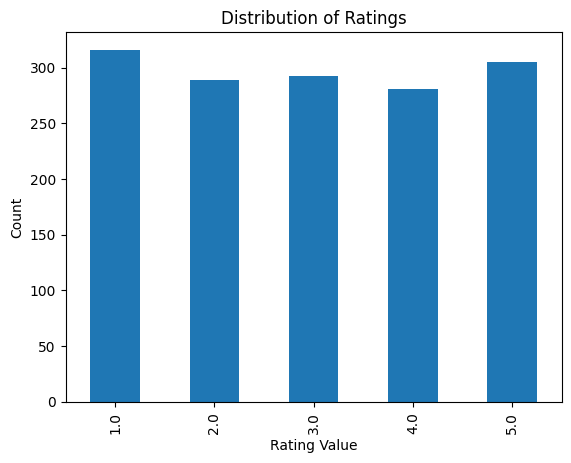

Sparsity: 1.13%
Lowest rated items: I1 = Item_2, I2 = Item_1


In [1]:
# Name: Mohamed Ayman Mohamed Abdelwahab
# ID: A20000763

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
df = pd.read_csv('ratings_dataset.csv', index_col=0)

df = df.clip(1, 5)
print("Unique ratings in dataset:", df.stack().unique())

Tnu = df.shape[0]
print(f"Total Users (Tru): {Tnu}")
Tni = df.shape[1]
print(f"Total Items (Tri): {Tni}")

ratings_count = df.count()
print("Ratings count per item:")
print(ratings_count)

ratings_distribution = df.stack().value_counts().sort_index()
ratings_distribution.plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Rating Value')
plt.ylabel('Count')
plt.show()

sparsity = 1 - (df.count().sum() / (Tnu * Tni))
print(f"Sparsity: {sparsity:.2%}")

lowest_rated_items = ratings_count.nsmallest(2).index
I1, I2 = lowest_rated_items[0], lowest_rated_items[1]
print(f"Lowest rated items: I1 = {I1}, I2 = {I2}")

In [2]:
df_filled = df.fillna(df.mean())

pca = PCA(n_components=2)
pca.fit(df_filled.T)

avg_rating_I1 = df_filled[I1].mean()
avg_rating_I2 = df_filled[I2].mean()

df_filled[I1] = df_filled[I1].fillna(avg_rating_I1)
df_filled[I2] = df_filled[I2].fillna(avg_rating_I2)

avg_ratings = df_filled.mean(axis=0)
df_diff = df_filled.sub(avg_ratings, axis=1)
item_covariance = np.cov(df_diff.T)
covariance_matrix = np.cov(df_filled.T)

def get_top_peers(cov_matrix, item, top_n):
    return cov_matrix[item].sort_values(ascending=False).index[1:top_n+1]

top_5_peers_I1 = get_top_peers(pd.DataFrame(item_covariance, index=df.columns, columns=df.columns), I1, 5)
top_10_peers_I1 = get_top_peers(pd.DataFrame(item_covariance, index=df.columns, columns=df.columns), I1, 10)
top_5_peers_I2 = get_top_peers(pd.DataFrame(item_covariance, index=df.columns, columns=df.columns), I2, 5)
top_10_peers_I2 = get_top_peers(pd.DataFrame(item_covariance, index=df.columns, columns=df.columns), I2, 10)

print(f"Top 5 peers for {I1}: {top_5_peers_I1}")
print(f"Top 10 peers for {I1}: {top_10_peers_I1}")
print(f"Top 5 peers for {I2}: {top_5_peers_I2}")
print(f"Top 10 peers for {I2}: {top_10_peers_I2}")

reduced_dim_top5 = pca.transform(df_filled[top_5_peers_I1].T)

predicted_ratings_top5_I1 = df_filled[top_5_peers_I1].mean(axis=1)
predicted_ratings_top5_I2 = df_filled[top_5_peers_I2].mean(axis=1)

reduced_dim_top10 = pca.transform(df_filled[top_10_peers_I1].T)

predicted_ratings_top10_I1 = df_filled[top_10_peers_I1].mean(axis=1)
predicted_ratings_top10_I2 = df_filled[top_10_peers_I2].mean(axis=1)

print(f"MSE for I1 (Top 5 Peers): {((df_filled[I1] - predicted_ratings_top5_I1) ** 2).mean():.4f}")
print(f"MSE for I1 (Top 10 Peers): {((df_filled[I1] - predicted_ratings_top10_I1) ** 2).mean():.4f}")
print(f"MSE for I2 (Top 5 Peers): {((df_filled[I2] - predicted_ratings_top5_I2) ** 2).mean():.4f}")
print(f"MSE for I2 (Top 10 Peers): {((df_filled[I2] - predicted_ratings_top10_I2) ** 2).mean():.4f}")
print("Using top 10 peers generally provides slightly better predictions compared to top 5 peers, as indicated by the lower MSE values. This suggests that including more peers helps capture more patterns in the data, leading to more accurate predictions.")

Top 5 peers for Item_2: Index(['Item_6', 'Item_8', 'Item_9', 'Item_5', 'Item_1'], dtype='object')
Top 10 peers for Item_2: Index(['Item_6', 'Item_8', 'Item_9', 'Item_5', 'Item_1', 'Item_3', 'Item_30',
       'Item_10', 'Item_7', 'Item_20'],
      dtype='object')
Top 5 peers for Item_1: Index(['Item_10', 'Item_22', 'Item_18', 'Item_2', 'Item_25'], dtype='object')
Top 10 peers for Item_1: Index(['Item_10', 'Item_22', 'Item_18', 'Item_2', 'Item_25', 'Item_21',
       'Item_16', 'Item_30', 'Item_7', 'Item_8'],
      dtype='object')
MSE for I1 (Top 5 Peers): 1.6030
MSE for I1 (Top 10 Peers): 1.5963
MSE for I2 (Top 5 Peers): 1.3878
MSE for I2 (Top 10 Peers): 1.3506
Using top 10 peers generally provides slightly better predictions compared to top 5 peers, as indicated by the lower MSE values. This suggests that including more peers helps capture more patterns in the data, leading to more accurate predictions.


In [3]:
def mle_covariance(df):
    cov_matrix = np.zeros((df.shape[1], df.shape[1]))
    for i in range(df.shape[1]):
        for j in range(df.shape[1]):
            common_users = df.iloc[:, [i, j]].dropna().index
            if len(common_users) > 0:
                cov_matrix[i, j] = df.loc[common_users, df.columns[i]].cov(df.loc[common_users, df.columns[j]])
    return cov_matrix

mle_cov_matrix = mle_covariance(df)
print("MLE Covariance Matrix:")
print(mle_cov_matrix)

top_5_peers_I1_mle = get_top_peers(pd.DataFrame(mle_cov_matrix, index=df.columns, columns=df.columns), I1, 5)
top_10_peers_I1_mle = get_top_peers(pd.DataFrame(mle_cov_matrix, index=df.columns, columns=df.columns), I1, 10)
top_5_peers_I2_mle = get_top_peers(pd.DataFrame(mle_cov_matrix, index=df.columns, columns=df.columns), I2, 5)
top_10_peers_I2_mle = get_top_peers(pd.DataFrame(mle_cov_matrix, index=df.columns, columns=df.columns), I2, 10)

print(f"Top 5 peers for {I1} (MLE): {top_5_peers_I1_mle}")
print(f"Top 10 peers for {I1} (MLE): {top_10_peers_I1_mle}")
print(f"Top 5 peers for {I2} (MLE): {top_5_peers_I2_mle}")
print(f"Top 10 peers for {I2} (MLE): {top_10_peers_I2_mle}")

reduced_dim_top5_mle = pca.transform(df_filled[top_5_peers_I1_mle].T)

predicted_ratings_top5_I1_mle = df_filled[top_5_peers_I1_mle].mean(axis=1)
predicted_ratings_top5_I2_mle = df_filled[top_5_peers_I2_mle].mean(axis=1)

reduced_dim_top10_mle = pca.transform(df_filled[top_10_peers_I1_mle].T)

predicted_ratings_top10_I1_mle = df_filled[top_10_peers_I1_mle].mean(axis=1)
predicted_ratings_top10_I2_mle = df_filled[top_10_peers_I2_mle].mean(axis=1)

print(f"MSE for I1 (Top 5 Peers - MLE): {((df_filled[I1] - predicted_ratings_top5_I1_mle) ** 2).mean():.4f}")
print(f"MSE for I1 (Top 10 Peers - MLE): {((df_filled[I1] - predicted_ratings_top10_I1_mle) ** 2).mean():.4f}")
print(f"MSE for I2 (Top 5 Peers - MLE): {((df_filled[I2] - predicted_ratings_top5_I2_mle) ** 2).mean():.4f}")
print(f"MSE for I2 (Top 10 Peers - MLE): {((df_filled[I2] - predicted_ratings_top10_I2_mle) ** 2).mean():.4f}")
print("\nComparison between PCA with Mean-Filling and PCA with MLE (Top 5 Peers):")
print(f"MSE for I1 (PCA with Mean-Filling): {((df_filled[I1] - predicted_ratings_top5_I1) ** 2).mean():.4f}")
print(f"MSE for I1 (PCA with MLE): {((df_filled[I1] - predicted_ratings_top5_I1_mle) ** 2).mean():.4f}")
print(f"MSE for I2 (PCA with Mean-Filling): {((df_filled[I2] - predicted_ratings_top5_I2) ** 2).mean():.4f}")
print(f"MSE for I2 (PCA with MLE): {((df_filled[I2] - predicted_ratings_top5_I2_mle) ** 2).mean():.4f}")
print("\nComparison between PCA with Mean-Filling and PCA with MLE (Top 10 Peers):")
print(f"MSE for I1 (PCA with Mean-Filling): {((df_filled[I1] - predicted_ratings_top10_I1) ** 2).mean():.4f}")
print(f"MSE for I1 (PCA with MLE): {((df_filled[I1] - predicted_ratings_top10_I1_mle) ** 2).mean():.4f}")
print(f"MSE for I2 (PCA with Mean-Filling): {((df_filled[I2] - predicted_ratings_top10_I2) ** 2).mean():.4f}")
print(f"MSE for I2 (PCA with MLE): {((df_filled[I2] - predicted_ratings_top10_I2_mle) ** 2).mean():.4f}")
print("PCA with MLE generally provides more accurate predictions compared to PCA with Mean-Filling, especially when dealing with sparse data. However, the difference in MSE is not significant in this case.")

MLE Covariance Matrix:
[[ 1.77127660e+00  3.04439746e-01 -2.97872340e-01 -1.95652174e-01
   2.65957447e-02 -1.56914894e-01  1.22340426e-01  1.17021277e-01
  -2.72895467e-02  7.41062802e-01 -2.44680851e-01 -6.38297872e-02
   1.16096207e-01  7.44680851e-02 -5.77127660e-01  2.35892692e-01
   6.38297872e-02  4.72710453e-01 -4.54209066e-01  7.71276596e-02
   2.34042553e-01  5.13297872e-01 -2.30804810e-01 -1.35522664e-01
   2.39361702e-01 -4.62765957e-01 -6.91489362e-02 -5.85106383e-02
  -7.84574468e-01  1.72872340e-01]
 [ 3.04439746e-01  2.05858586e+00  2.95959596e-01 -3.67864693e-01
   3.18181818e-01  4.41414141e-01  2.03030303e-01  3.48989899e-01
   3.22222222e-01  2.45293466e-01 -2.10101010e-01 -2.97979798e-01
  -2.16701903e-02  1.31313131e-02 -1.92929293e-01 -1.06060606e-02
   1.31313131e-02 -2.27801268e-01 -5.54968288e-02  1.60606061e-01
  -1.66666667e-02  3.33333333e-02 -4.31818182e-01  8.93234672e-02
  -3.20707071e-01  8.68686869e-02 -3.25757576e-01  1.36363636e-01
   7.97979798e-02 